# FloodSR Example: `rss_dudelange_A`

Run FloodSR inference with default runtime options on `tests/data/rss_dudelange_A`, 
plot inputs/outputs, and compute performance against `tests/data/rss_dudelange_A/hires003.tif`.

In [1]:
# Set project root and keep notebook execution deterministic.
import os
from pathlib import Path

PROJECT_ROOT = Path(os.getenv('PROJECT_ROOT', '/workspace')).resolve()
if not PROJECT_ROOT.exists():
    PROJECT_ROOT = Path.cwd().resolve()
os.chdir(PROJECT_ROOT)
print(f'cwd set to {Path.cwd()}')

cwd set to /workspace


# IMPORTS

In [2]:
# Import runtime and scientific dependencies used by this notebook.
import importlib.metadata as md
import json

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import Resampling, reproject

In [3]:
from floodsr.tohr import tohr
from misc.eval import compute_depth_error_metrics
from floodsr.preprocessing import (
    _read_single_band_raster,
    replace_nodata_with_zero,
    resolve_preprocess_config,
)

for pkg_name in ['floodsr', 'numpy', 'pandas', 'matplotlib', 'rasterio', 'onnxruntime']:
    try:
        print(f'{pkg_name}: {md.version(pkg_name)}')
    except md.PackageNotFoundError:
        print(f'{pkg_name}: MISSING')

floodsr: 0.0.1
numpy: 2.4.2
pandas: 3.0.1
matplotlib: 3.10.8
rasterio: 1.5.0
onnxruntime: 1.24.2


# INPUTS

In [4]:
# Resolve default example inputs and the local ONNX model artifact.
case_dir = Path('tests/data/rss_dudelange_A')
artifact = json.loads((case_dir / 'metrics.json').read_text())

depth_lr_fp = case_dir / artifact['lowres_fp']
dem_hr_fp = case_dir / artifact['dem_fp']
depth_hr_truth_fp = case_dir / artifact['truth_fp']

model_fp = Path('_inputs') / artifact['model_version'] / artifact['model_file_name']
output_dir = Path('build') / 'examples'
output_fp = output_dir / f'{depth_lr_fp.stem}_sr.tif'

assert case_dir.exists(), f'missing case dir: {case_dir}'
assert depth_lr_fp.exists(), f'missing low-res depth raster: {depth_lr_fp}'
assert dem_hr_fp.exists(), f'missing DEM raster: {dem_hr_fp}'
assert depth_hr_truth_fp.exists(), f'missing hi-res truth raster: {depth_hr_truth_fp}'
assert model_fp.exists(), f'missing model file: {model_fp}'

print('depth_lr_fp')
print(f'    {depth_lr_fp}')
print('dem_hr_fp')
print(f'    {dem_hr_fp}')
print('depth_hr_truth_fp')
print(f'    {depth_hr_truth_fp}')
print('model_fp')
print(f'    {model_fp}')
print(f"artifact compatibility note: {artifact['compatibility_reason']}")

depth_lr_fp
    tests/data/rss_dudelange_A/lowres030.tif
dem_hr_fp
    tests/data/rss_dudelange_A/hires003_dem.tif
depth_hr_truth_fp
    tests/data/rss_dudelange_A/hires003.tif
model_fp
    _inputs/4690176_0_1770580046_train_base_16/model_infer.onnx
artifact compatibility note: input raster ratio is 30m:3m (10x); inference rescales LR depth to model SCALE=16.


# HELPERS

In [5]:
# Define helpers for aligned raster reads and plot annotations.
def _pixel_size_m(profile):
    transform = profile.get('transform')
    if transform is None:
        return (float('nan'), float('nan'))
    if hasattr(transform, 'a') and hasattr(transform, 'e'):
        return (abs(float(transform.a)), abs(float(transform.e)))
    return (abs(float(transform[0])), abs(float(transform[4])))


def _fmt_res(res_xy):
    return f'({res_xy[0]:.6g}, {res_xy[1]:.6g})'


def _read_clean_raster(fp):
    arr, nodata, profile = _read_single_band_raster(fp)
    arr = replace_nodata_with_zero(arr, nodata)
    return arr.astype(np.float32, copy=False), profile


def _reproject_from_fp(src_fp, dst_profile, resampling):
    with rasterio.open(src_fp) as src_ds:
        out = np.zeros((int(dst_profile['height']), int(dst_profile['width'])), dtype=np.float32)
        src_nodata = src_ds.nodata
        reproject(
            source=rasterio.band(src_ds, 1),
            destination=out,
            src_transform=src_ds.transform,
            src_crs=src_ds.crs,
            src_nodata=src_nodata,
            dst_transform=dst_profile['transform'],
            dst_crs=dst_profile['crs'],
            dst_nodata=0.0,
            resampling=resampling,
        )
    if src_nodata is not None and not np.isclose(src_nodata, 0.0):
        out = replace_nodata_with_zero(out, src_nodata)
    return out.astype(np.float32, copy=False)


def _stats_text(values):
    if values.size == 0:
        return 'n=0'
    lines = [
        f'n={values.size:,}',
        f'min={values.min():.4f}',
        f'mean={values.mean():.4f}',
        f'max={values.max():.4f}',
        f'std={values.std():.4f}',
    ]
    return chr(10).join(lines)


def _fmt_metric(value, ndigits=4):
    if value is None or not np.isfinite(value):
        return 'nan'
    return f'{value:.{ndigits}f}'

def _reproject_array(src_array, src_profile, dst_profile, resampling):
    out = np.zeros((int(dst_profile['height']), int(dst_profile['width'])), dtype=np.float32)
    reproject(
        source=src_array.astype(np.float32, copy=False),
        destination=out,
        src_transform=src_profile['transform'],
        src_crs=src_profile['crs'],
        src_nodata=None,
        dst_transform=dst_profile['transform'],
        dst_crs=dst_profile['crs'],
        dst_nodata=0.0,
        resampling=resampling,
    )
    return out.astype(np.float32, copy=False)

# RUN INFERENCE

In [6]:
# Run FloodSR inference with defaults (only required args passed).
output_dir.mkdir(parents=True, exist_ok=True)
infer_result = tohr(
    model_version=artifact['model_version'],
    model_fp=model_fp,
    depth_lr_fp=depth_lr_fp,
    dem_hr_fp=dem_hr_fp,
    output_fp=output_fp,
)
print(json.dumps(infer_result, indent=2, sort_keys=True))

windowed inference:   0%|          | 0/20 [00:00<?, ?window/s]

windowed inference:  15%|█▌        | 3/20 [00:00<00:00, 22.79window/s]

windowed inference:  30%|███       | 6/20 [00:00<00:00, 25.01window/s]

windowed inference:  45%|████▌     | 9/20 [00:00<00:00, 24.44window/s]

windowed inference:  60%|██████    | 12/20 [00:00<00:00, 25.59window/s]

windowed inference:  75%|███████▌  | 15/20 [00:00<00:00, 26.77window/s]

windowed inference:  95%|█████████▌| 19/20 [00:00<00:00, 29.27window/s]

windowed inference: 100%|██████████| 20/20 [00:00<00:00, 26.98window/s]

windowed inference:   0%|          | 0/35 [00:00<?, ?window/s]

windowed inference:  11%|█▏        | 4/35 [00:00<00:00, 35.31window/s]

windowed inference:  26%|██▌       | 9/35 [00:00<00:00, 41.60window/s]

windowed inference:  40%|████      | 14/35 [00:00<00:00, 34.46window/s]

windowed inference:  51%|█████▏    | 18/35 [00:00<00:00, 33.72window/s]

windowed inference:  63%|██████▎   | 22/35 [00:00<00:00, 31.43window/s]

windowed inference:  74%|███████▍  | 26/35 [00:00<00:00, 31.73window/s]

windowed inference:  89%|████████▊ | 31/35 [00:00<00:00, 34.61window/s]

windowed inference: 100%|██████████| 35/35 [00:00<00:00, 35.83window/s]

{
  "output_fp": "/workspace/build/examples/lowres030_sr.tif",
  "preprocess": {
    "dem_pct_clip": 95.0,
    "dem_ref_stats": null,
    "dem_stats_used": {
      "p_clip": 95.0
    },
    "input_shape": {
      "aligned_dem_shape": [
        2030,
        2090
      ],
      "aligned_depth_shape": [
        126,
        130
      ],
      "crop_height": 2030,
      "crop_width": 2090
    },
    "max_depth": 5.0,
    "model_scale": 16,
    "prepared_inputs": {
      "dem_hr_prepared_fp": "/home/cefect/LS/10_IO/2407_FHIMP/tmp/floodsr-prep-f7p2xea1/hires003_dem_prepped_dem.tif",
      "depth_lr_prepared_fp": "/home/cefect/LS/10_IO/2407_FHIMP/tmp/floodsr-prep-f7p2xea1/lowres030_prepped_depth.tif",
      "prepped_depth_was_resampled": true
    },
    "tile_cache_size": 49,
    "tile_overlap_lr": 8,
    "tile_size_hr": 512,
    "tile_size_lr": 32,
    "window_method": "feather"
  },
  "runtime_s": 2.7952960320108104
}


In [7]:
# Load rasters and align validation/baselines to the prediction grid.
depth_lr_raw, depth_lr_profile = _read_clean_raster(depth_lr_fp)
dem_hr_raw, dem_hr_profile = _read_clean_raster(dem_hr_fp)
depth_hr_truth_raw, depth_hr_truth_profile = _read_clean_raster(depth_hr_truth_fp)
pred_depth_m, pred_profile = _read_clean_raster(output_fp)

max_depth = float(resolve_preprocess_config(model_fp)['max_depth'])

# Parameter block for validation logic and metric interpretation.
params = {
    'dry_depth_thresh_m': 1e-3,
    'metric_directionality': {
        'psnr': 'higher',
        'ssim': 'higher',
        'mase_m': 'lower',
        'rmse_m': 'lower',
        'rmse_wet_m': 'lower',
        'bias_m': 'abs_lower',
    },
}

dry_depth_thresh_m = float(params['dry_depth_thresh_m'])
truth_aligned = _reproject_from_fp(depth_hr_truth_fp, pred_profile, Resampling.nearest)
lr_nearest = _reproject_from_fp(depth_lr_fp, pred_profile, Resampling.nearest)
lr_bilinear = _reproject_from_fp(depth_lr_fp, pred_profile, Resampling.bilinear)

print(f'resolved max_depth={max_depth}')
print(f"dry_depth_thresh_m={dry_depth_thresh_m}")
print(f'prediction shape={pred_depth_m.shape}, res={_fmt_res(_pixel_size_m(pred_profile))}')
print(f"metric_directionality={params['metric_directionality']}")

resolved max_depth=5.0
dry_depth_thresh_m=0.001
prediction shape=(2030, 2090), res=(3, 3)
metric_directionality={'psnr': 'higher', 'ssim': 'higher', 'mase_m': 'lower', 'rmse_m': 'lower', 'rmse_wet_m': 'lower', 'bias_m': 'abs_lower'}


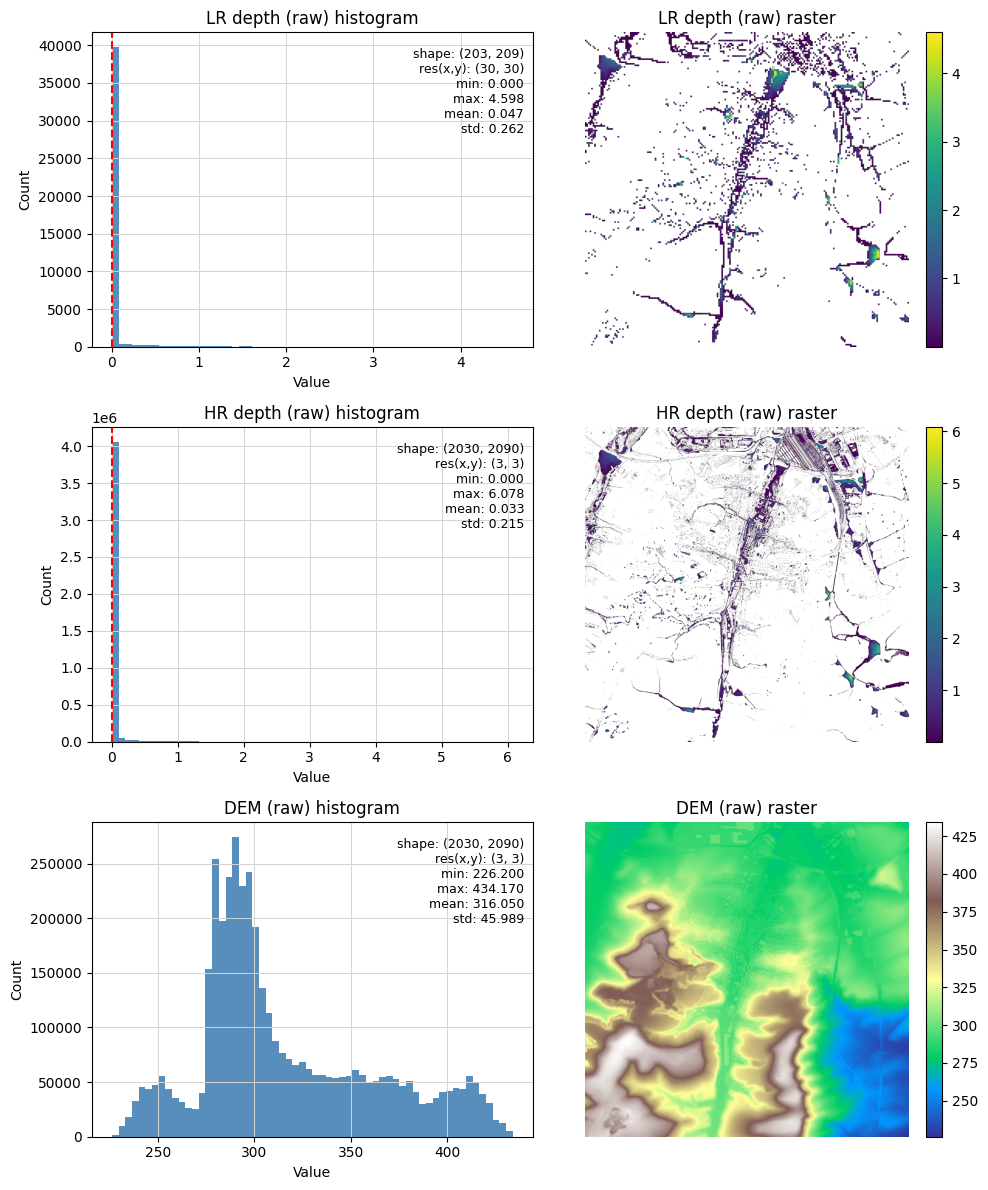

In [8]:
# Plot raw input diagnostics in the same histogram+raster style used in dev/inference.ipynb.
plot_specs_raw = [
    ('LR depth (raw)', depth_lr_raw, 'viridis', True, dry_depth_thresh_m, _pixel_size_m(depth_lr_profile)),
    ('HR depth (raw)', depth_hr_truth_raw, 'viridis', True, dry_depth_thresh_m, _pixel_size_m(depth_hr_truth_profile)),
    ('DEM (raw)', dem_hr_raw, 'terrain', False, None, _pixel_size_m(dem_hr_profile)),
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for row_idx, (title, arr, cmap, use_dry_mask, dry_thresh, res_xy) in enumerate(plot_specs_raw):
    arr = np.asarray(arr)
    vals = arr[np.isfinite(arr)]

    ax_hist = axes[row_idx, 0]
    ax_raster = axes[row_idx, 1]

    ax_hist.hist(vals, bins=60, color='steelblue', alpha=0.9)
    if use_dry_mask:
        ax_hist.axvline(dry_thresh, color='red', linestyle='--', linewidth=1.5)
    ax_hist.set_title(f'{title} histogram')
    ax_hist.set_xlabel('Value')
    ax_hist.set_ylabel('Count')
    ax_hist.grid(color='lightgrey', linestyle='-', linewidth=0.7)

    text_lines = [
        f'shape: {arr.shape}',
        f'res(x,y): {_fmt_res(res_xy)}',
        f'min: {vals.min():.3f}',
        f'max: {vals.max():.3f}',
        f'mean: {vals.mean():.3f}',
        f'std: {vals.std():.3f}',
    ]
    ax_hist.text(
        0.98,
        0.95,
        chr(10).join(text_lines),
        transform=ax_hist.transAxes,
        fontsize=9,
        verticalalignment='top',
        horizontalalignment='right',
    )

    raster_arr = np.ma.masked_where(arr < dry_thresh, arr) if use_dry_mask else arr
    im = ax_raster.imshow(raster_arr, cmap=cmap)
    ax_raster.set_title(f'{title} raster')
    ax_raster.set_axis_off()
    fig.colorbar(im, ax=ax_raster, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# VALIDATION

In [9]:
# Compute SR and bilinear performance against hi-res validation and show a dev/inference-style table.
metrics_lr = compute_depth_error_metrics(
    reference_depth_m=truth_aligned,
    estimate_depth_m=lr_nearest,
    max_depth=max_depth,
    dry_depth_thresh_m=dry_depth_thresh_m,
)
metrics_bilinear = compute_depth_error_metrics(
    reference_depth_m=truth_aligned,
    estimate_depth_m=lr_bilinear,
    max_depth=max_depth,
    dry_depth_thresh_m=dry_depth_thresh_m,
)
metrics_sr = compute_depth_error_metrics(
    reference_depth_m=truth_aligned,
    estimate_depth_m=pred_depth_m,
    max_depth=max_depth,
    dry_depth_thresh_m=dry_depth_thresh_m,
)

metric_keys = ['psnr', 'ssim', 'mase_m', 'rmse_m', 'rmse_wet_m', 'bias_m']
assert set(metric_keys) == set(params['metric_directionality']), 'metric directionality keys must match metric_keys'
metrics_df = pd.DataFrame(
    {
        'FloodSR': {k: metrics_sr[k] for k in metric_keys},
        'Bilinear': {k: metrics_bilinear[k] for k in metric_keys},
    }
)
metrics_df['delta'] = metrics_df['FloodSR'] - metrics_df['Bilinear']

# Flag whether FloodSR improved over bilinear using per-metric directionality rules.
better_l = []
for metric_name in metrics_df.index:
    sr_v = float(metrics_df.at[metric_name, 'FloodSR'])
    bl_v = float(metrics_df.at[metric_name, 'Bilinear'])
    direction = params['metric_directionality'][metric_name]
    if direction == 'higher':
        better_l.append(sr_v > bl_v)
    elif direction == 'lower':
        better_l.append(sr_v < bl_v)
    elif direction == 'abs_lower':
        better_l.append(abs(sr_v) < abs(bl_v))
    else:
        raise AssertionError(f'unsupported directionality: {direction}')
metrics_df['better'] = better_l

print('Artifact reference metrics (tests/data/rss_dudelange_A/metrics.json):')
print(json.dumps(artifact['metrics'], indent=2, sort_keys=True))
print('Notebook-computed metrics:')
display(metrics_df.round(6))

Artifact reference metrics (tests/data/rss_dudelange_A/metrics.json):
{
  "mase_m": 0.03648277458203141,
  "rmse_m": 0.19901361530506798,
  "ssim": 0.4107624337447762
}
Notebook-computed metrics:


,FloodSR,Bilinear,delta,better
psnr,28.001744,28.384239,-0.382495,False
ssim,0.410762,0.675103,-0.264341,False
mase_m,0.036483,0.041497,-0.005014,True
rmse_m,0.199014,0.190440,0.008574,False
rmse_wet_m,0.640903,0.482477,0.158426,False
bias_m,-0.019017,0.014644,-0.033661,False


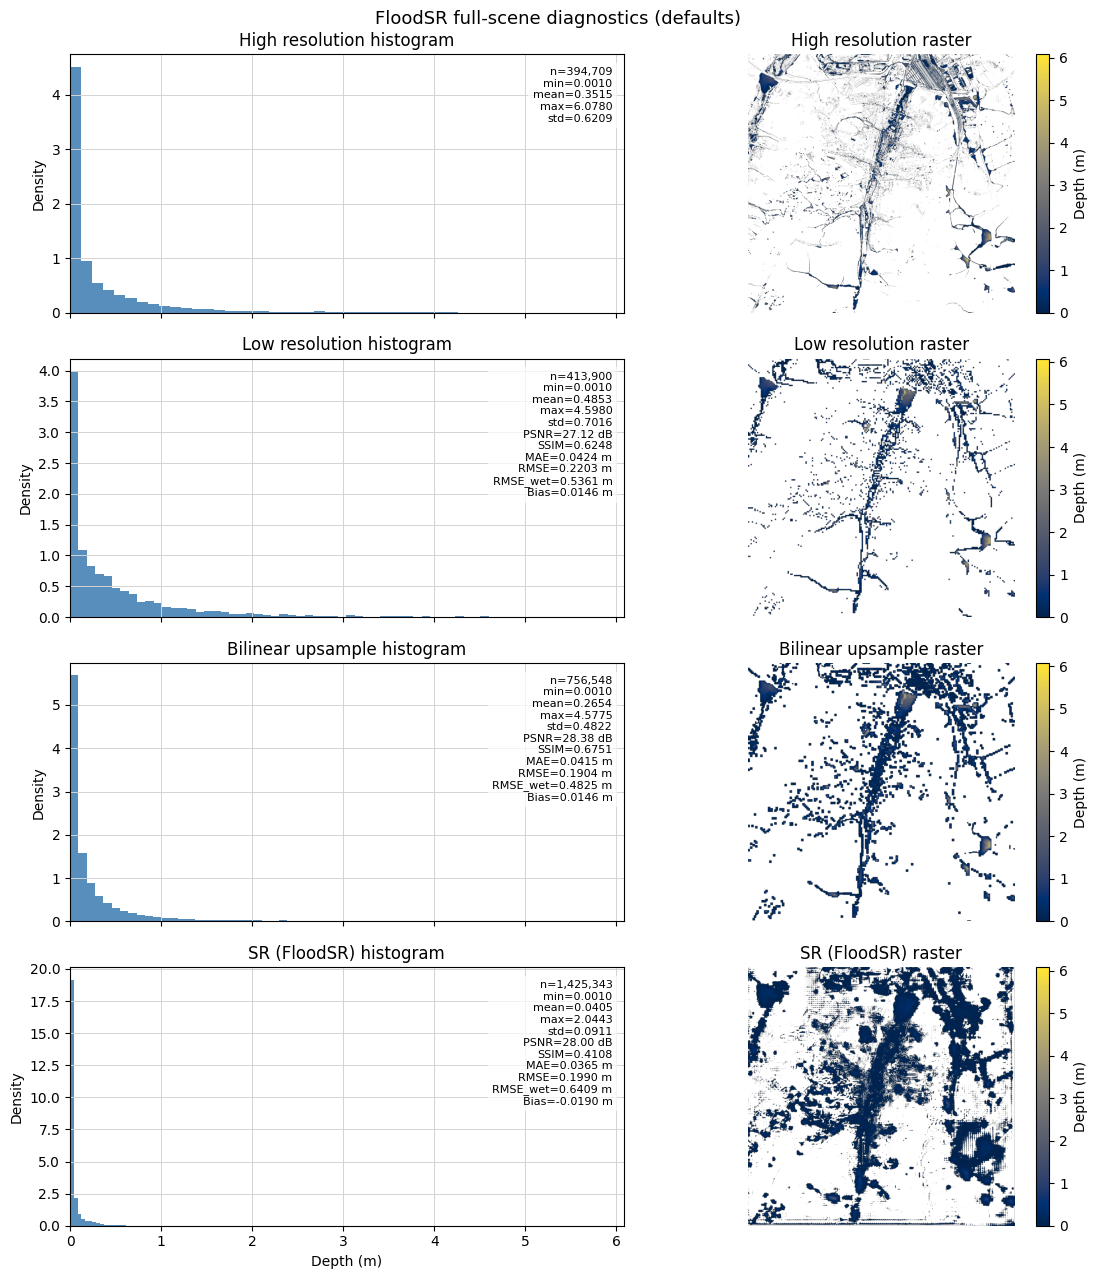

In [10]:
# Render final output comparison in the same 4-row histogram+raster diagnostics style.
rows = [
    ('High resolution', truth_aligned, None),
    ('Low resolution', lr_nearest, 'lr'),
    ('Bilinear upsample', lr_bilinear, 'bl'),
    ('SR (FloodSR)', pred_depth_m, 'sr'),
]
row_metrics = {'lr': metrics_lr, 'bl': metrics_bilinear, 'sr': metrics_sr}
vmax_depth = max(float(np.nanmax(truth_aligned)), float(np.nanmax(pred_depth_m)), max_depth)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(11, 13), sharex='col')

for row_idx, (title, img, metric_prefix) in enumerate(rows):
    ax_hist = axes[row_idx, 0]
    ax_img = axes[row_idx, 1]

    masked = np.ma.masked_where(img < dry_depth_thresh_m, img)
    vals = masked.compressed()

    ax_hist.hist(vals, bins=50, density=True, color='steelblue', alpha=0.9)
    ax_hist.axvline(dry_depth_thresh_m, color='red', linestyle='--', linewidth=1.2)
    ax_hist.set_ylabel('Density')
    ax_hist.set_xlim(0.0, vmax_depth)
    ax_hist.grid(color='lightgrey', linestyle='-', linewidth=0.7)
    if row_idx == len(rows) - 1:
        ax_hist.set_xlabel('Depth (m)')

    info_lines = [_stats_text(vals)]
    if metric_prefix is not None:
        metric_group = row_metrics[metric_prefix]
        info_lines.extend(
            [
                f"PSNR={_fmt_metric(metric_group['psnr'], 2)} dB",
                f"SSIM={_fmt_metric(metric_group['ssim'])}",
                f"MAE={_fmt_metric(metric_group['mae_m'])} m",
                f"RMSE={_fmt_metric(metric_group['rmse_m'])} m",
                f"RMSE_wet={_fmt_metric(metric_group['rmse_wet_m'])} m",
                f"Bias={_fmt_metric(metric_group['bias_m'])} m",
            ]
        )

    ax_hist.text(
        0.98,
        0.95,
        chr(10).join(info_lines),
        transform=ax_hist.transAxes,
        ha='right',
        va='top',
        fontsize=8,
        bbox={'facecolor': 'white', 'alpha': 0.7, 'edgecolor': 'none', 'pad': 3},
    )
    ax_hist.set_title(f'{title} histogram')

    im = ax_img.imshow(masked, cmap='cividis', vmin=0.0, vmax=vmax_depth)
    ax_img.set_title(f'{title} raster')
    ax_img.set_axis_off()
    fig.colorbar(im, ax=ax_img, fraction=0.046, pad=0.04, label='Depth (m)')

fig.suptitle('FloodSR full-scene diagnostics (defaults)', fontsize=13)
plt.tight_layout()
plt.show()